# <center>Recurrent Neural Networks</center>
## <center>Inclass Project 3 - MA4144</center>

This project contains 10 tasks/questions to be completed, some require written answers. Open a markdown cell below the respective question that require written answers and provide (type) your answers. Questions that required written answers are given in blue fonts. Almost all written questions are open ended, they do not have a correct or wrong answer. You are free to give your opinions, but please provide related answers within the context.

After finishing project run the entire notebook once and **save the notebook as a pdf** (File menu -> Save and Export Notebook As -> PDF). You are **required to upload this PDF on moodle**.

***

## Outline of the project

The aim of the project is to build a RNN model to suggest autocompletion of half typed words. You may have seen this in many day today applications; typing an email, a text message etc. For example, suppose you type in the four letter "univ", the application may suggest you to autocomplete it by "university".

[Autocomplete](https://d33v4339jhl8k0.cloudfront.net/docs/assets/5c12e83004286304a71d5b72/images/66d0cb106eb51e63b8f9fbc6/file-gBQe016VYt.gif)

We will train a RNN to suggest possible autocompletes given $3$ - $4$ starting letters. That is if we input a string "univ" hopefully we expect to see an output like "university", "universal" etc.

For this we will use a text file (wordlist.txt) containing 10,000 common English words (you'll find the file on the moodle link). The list of words will be the "**vocabulary**" for our model.

We will use the Python **torch library** to implement our autocomplete model. 

***


Use the below cell to use any include any imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F

## Section 1: Preparing the vocabulary

In [2]:
WORD_SIZE = 13
num_layers = 1 
alphabet_size = 27

**Q1.** In the following cell provide code to load the text file (each word is in a newline), then extract the words (in lowercase) into a list.

For practical reasons of training the model we will only use words that are longer that $3$ letters and that have a maximum length of WORD_SIZE (this will be a constant we set at the beginning - you can change this and experiment with different WORD_SIZEs). As seen above it is set to $13$.

So out of the extracted list of words filter out those words that match our criteria on word length.

To train our model it is convenient to have words/strings of equal length. We will choose to convert every word to length of WORD_SIZE, by adding underscores to the end of the word if it is initially shorter than WORD_SIZE. For example, we will convert the word "university" (word length 10) into "university___" (wordlength 13). In your code include this conversion as well.

Store the processed WORD_SIZE lengthed strings in a list called vocab.

In [3]:
with open('wordlist.txt', 'r') as file:
    words = file.read().splitlines()

vocab = []

for word in words:
    word = word.lower() 
    if 3 < len(word) <= WORD_SIZE:  
        padded_word = word + '_' * (WORD_SIZE - len(word))  
        vocab.append(padded_word)  



<font color='blue'>In the above explanation it was mentioned "for practical reasons of training the model we will only use words that are longer that $3$ letters and that have a certain maximum length". In your opinion what could be those practical? Will hit help to build a better model?</font>

**Answer**

Normally, shorter words(length <= 3), provide limited information for the model to learn meaningful patterns. Including many short words in the training process can cause the model to overfit to those less informative patterns, which are not much useful for predicting longer words. Also, these short words do not provide enough context for the model to learn useful relationships between characters. This can introduce unnecessary complexity to the model and make it harder for the model to generalize to more meaningful sequences. Therefore, training the model on longer words helps avoid overfitting to simplistic patterns and supports the development of a more generalized model with improved performance.

**Q2** To input words into the model, we will need to convert each letter/character into a number. as we have seen above, the only characters in our list vocab will be the underscore and lowercase english letters. so we will convert these $27$ characters into numbers as follows: underscore -> $0$, 'a' -> $1$, 'b' -> $2$, $\cdots$, 'z' -> $26$. In the following cell,

(i) Implement a method called char_to_num, that takes in a valid character and outputs its numerical assignment.

(ii) Implement a method called num_to_char, that takes in a valid number from $0$ to $26$ and outputs the corresponding character.

(iii) Implement a method called word_to_numlist, that takes in a word from our vocabulary and outputs a (torch) tensor of numbers that corresponds to each character in the word in that order. For example: the word "united_______" will be converted to tensor([21, 14,  9, 20,  5,  4,  0,  0,  0,  0,  0,  0,  0]). You are encouraged to use your char_to_num method for this.

(iv) Implement a method called numlist_to_word, that does the opposite of the above described word_to_numlist, given a tensor of numbers from $0$ to $26$, outputs the corresponding word. You are encouraged to use your  num_to_char method for this.

Note: As mentioned since we are using the torch library we will be using tensors instead of the usual python lists or numpy arrays. Tensors are the list equivalent in torch. Torch models only accept tensors as input and they output tensors.

In [4]:
def char_to_num(char):

    if char == '_':
        num = 0
    elif ord('a') <= ord(char) <= ord('z'):
        num = ord(char) - ord('a') + 1 
    else:
        print("Invalid Character ",char)
    
    return(num)

def num_to_char(num):
    
    if num == 0:
        char = '_'  

    elif 1 <= num <= 26:
        char = chr(num - 1 + ord('a'))  
    else:
        print("Invalid number ", num)

    return(char)

def word_to_numlist(word):

    numlist = torch.tensor([char_to_num(char) for char in word]) 

    return(numlist)

def numlist_to_word(numlist):
    word = ""  
    
    for num in numlist:
        word += num_to_char(num.item()) 
    
    return(word)

print(word_to_numlist("united_______"))

sample_tensor = torch.tensor([21, 14,  9, 20,  5,  4,  0,  0,  0,  0,  0,  0,  0])
print(numlist_to_word(sample_tensor))

tensor([21, 14,  9, 20,  5,  4,  0,  0,  0,  0,  0,  0,  0])
united_______


<font color='blue'>We convert letter into just numbers based on their aphabetical order, I claim that it is a very bad way to encode data such as letters to be fed into learning models, please write your explanation to or against my claim. If you are searching for reasons, the keyword 'categorical data' may be useful. Although the letters in our case are not treated as categorical data, the same reasons as for categorical data is applicable. Even if my claim is valid, at the end it won't matter due to something called "embedding layers" that we will use in our model. What is an embedding layer? What is it's purpose? Explain.</font>

**Answer** 


I agree with the above claim.
In categorical data, incorrect encoding can introduce unintended biases or relationships. Similarly, when letters are encoded based on their alphabetic order, it creates a false sense of order between them. For example encoding 'a' as 1, b as '2', and z as '26' can give a model the idea that 'b' is more similar to 'a' than 'z', which is incorrect.  This could make the model learn non-existent relationships, ultimately reducing its ability to learn meaningful patterns from the data. Therefore, encoding letters in this way is not suitable for training the model.

*Embedding Layers*

Embedding layers in LSTM convert categorical data into continuous vector representations. These layers map each category to a high-dimensional vector, allowing the model to learn important information about the relationships between the categories.
In this autocomplete model, The embedding layer takes integer-encoded input and maps these integers to dense vectors. This allows the model to learn context-related information as letters that often appear in similar contexts (eg. 'i', 'n', 'g' ) will have embeddings that are closer to each other in the vector space. 
Additionally, using embedding layers reduces the input dimensionality compared to methods like one-hot encoding. The embedding layer compresses the information into a dense, lower-dimensional representation, allowing the model to handle input data efficiently.

## Section 2: Implementing the Autocomplete model

We will implement a RNN model based on LSTM. The [video tutorial](https://www.youtube.com/watch?v=tL5puCeDr-o) will be useful. Our model will be only one hidden layer, but feel free to sophisticate with more layers after the project for your own experiments.

Our model will contain all the training and prediction methods as single package in a class (autocompleteModel) we will define and implement below.

In [5]:
LEARNING_RATE = 0.005

In [26]:
class autocompleteModel(nn.Module):

    #Constructor
    def __init__(self, alphabet_size, embed_dim, hidden_size, num_layers):
        super().__init__()

        #Set the input parameters to self parameters

        self.alphabet_size = alphabet_size  
        self.embed_dim = embed_dim          
        self.hidden_size = hidden_size      
        self.num_layers = num_layers       

        #Initialize the layers in the model:
        #1 embedding layer, 1 - LSTM cell (hidden layer), 1 fully connected layer with linear activation

        self.embedding = nn.Embedding(num_embeddings=self.alphabet_size, embedding_dim=self.embed_dim)
        
        #one LSTM cell
        self.lstm_cell = nn.LSTMCell(input_size=self.embed_dim, hidden_size=self.hidden_size)

        self.fc = nn.Linear(in_features=self.hidden_size, out_features=self.alphabet_size)


    #Feedforward
    def forward(self, character, hidden_state, cell_state): #character is given as number

        #Perform feedforward in order

        #1. Embed the input (one character represented by a number)
        embedded = self.embedding(character)

        #2. Feed the embedded output to the LSTM cell
        #get new hidden state and cell state by giving previous hidden state and cell state 
        (hidden_state, cell_state) = self.lstm_cell(embedded, (hidden_state, cell_state))

        #3. Feed the LSTM output to the fully connected layer to obtain the output
        output = self.fc(hidden_state)

        #4. return the output, and both the hidden state and cell state from the LSTM cell output    
        return output, hidden_state, cell_state


    #Intialize the first hidden state and cell state (for the start of a word) as zero tensors of required length.
    def initial_state(self):

        h0 = torch.zeros(self.hidden_size)
        c0 = torch.zeros(self.hidden_size)
    
        return (h0, c0)


    #Train the model in epochs given the vocab, the training will be fed in batches of batch_size
    def trainModel(self, vocab, epochs = 5, batch_size = 100):

        #Convert the model into train mode
        self.train()

        #Set the optimizer (ADAM), you may need to provide the model parameters  and learning rate
        optimizer = torch.optim.Adam(self.parameters(), lr=LEARNING_RATE)

        #Keep a log of the loss at the end of each training cycle.
        loss_log = []

        for e in range(epochs):
            
            # Shuffle the vocab list the start of each epoch
            random.shuffle(vocab)

            # Based on the size of the training set and batch size, calculate the number of iterations
            num_iter = len(vocab) // batch_size

            for i in range(num_iter):
                # Set the loss to zero at the beginning of each training cycle
                loss = 0

                # Initialize the optimizer with zero_grad at the beginning of each training cycle
                optimizer.zero_grad()

                vocab_batch = vocab[i * batch_size: (i + 1) * batch_size]

                for word in vocab_batch:
                    
                    # Initialize the hidden state and cell state at the start of each word
                    hidden_state, cell_state = self.initial_state()

                    #Convert the word into a tensor of number and create input and target from the word
                    word_as_numlist = word_to_numlist(word)
                    
                    #Input will be the first WORD_SIZE - 1 charcters and target is the last WORD_SIZE - 1 charcters
                    input_numlist = torch.tensor(word_as_numlist[:WORD_SIZE-1])
                    target_numlist = torch.tensor(word_as_numlist[1:WORD_SIZE])

                    #Loop through each character (as a number) in the word
                    for c in range(WORD_SIZE - 1):
                        #Feed the cth character to the model (feedforward) and compute the loss (use cross entropy in torch)
                        input_character  = input_numlist[c]
                        target_character = target_numlist[c]


                        output, hidden_state, cell_state = self.forward(input_character, hidden_state, cell_state)
                    
                        # Compute the loss for this character using cross-entropy
                        loss += torch.nn.functional.cross_entropy(output, target_character)    

                # Compute the average loss per word in the batch and perform backpropagation (.backward())
                loss = loss / (batch_size)
                loss.backward()
                    
                #Update model parameters using the optimizer
                optimizer.step()

                #Update the loss_log 
                loss_log.append(loss.item())

            print("Epoch: ", e)

        # Plot a graph of the variation of the loss.
        plt.figure(figsize=(10, 5))
        plt.plot(loss_log, label='Loss', color='blue')
        plt.title('Loss Variation Over Epochs')
        plt.xlabel('Batch Number')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    #Perform autocmplete given a sample of strings (typically 3-5 starting letters)
    def autocomplete(self, sample):

        #Convert the model into evaluation mode
        self.eval()

        completed_list = []

        #In the following loop for each sample item initialize hidden and cell states, then predict the remaining characters
        #You will have to convert the output into a softmax (you may use your softmax method from the last project) probability distribution, then use torch.multinomial 
        for literal in sample:
            hidden_state, cell_state = self.initial_state()
            
            literal_as_numlist = word_to_numlist(literal)

            for c in range(len(literal)):
                input_char  = literal_as_numlist[c]
                output, hidden_state, cell_state = self.forward(input_char, hidden_state, cell_state)
            
            predicted_string = literal

             # Predict the next characters until WORD_SIZE is reached
            for _ in range(WORD_SIZE - len(literal)):
                probabilities = F.softmax(output, dim=0).detach()  
                next_char_index = torch.multinomial(probabilities, num_samples=1).item()
                predicted_char = num_to_char(next_char_index)

                if(predicted_char == "_"):
                    break

                predicted_string += predicted_char
                
                output, hidden_state, cell_state = self.forward(word_to_numlist(predicted_char)[0], hidden_state, cell_state)

            completed_list.append(predicted_string)

        return(completed_list)

## Section 3: Using and evaluating the model

(i) Feel free to initialize a autocompleteModel using different embedding dimensions and hidden layer sizes. Use different learning rates, epochs, batch sizes. Train the best model you can. Show the loss curves in you answers.

(ii) Evaluate it on different samples of partially filled in words. Eg: ["univ", "math", "neur", "engin"] etc. Please show outputs for different samples.

<font color='blue'>Comment on the results. Is it successful? Do you see familiar substrings in the generated tesxt such as "tion", "ing", "able" etc. What are your suggestions to improve the model?</font>

**Answer** 

The model was somewhat successful in predicting the expected endings of words. From thd diffrent combinations of hyperparameters, considerably accurate results were obtained for,

    embed_dim = 40  
    hidden_size = 80  
    batch_size = 90
    epochs = 10
    LEARNING_RATE = 0.005
Under this configuration, the model successfully predicted words such as 'neuron',  'prevent',  'differed', 'assists', 'secure', 'equation', 'import', 'passable', and 'obvious'. Additionally, model has learnt some familiar substrings  such as 'ive', 'ion', 'able', 'fic' and 'ious'  whic can be seen from predicted words such as 'applicative', 'equation', 'adminititive', etc. 

*Suggestions to imrove the model*

1. From the hyperparamter tuning it was identified that higher hidden_size, emdeding dimentions values along with higher number of epochs can lead to better performance of the model.  Larger hidden layers and embeddings can help the model learn more complex patterns and relationships in the data, while more epochs allow the model to fine-tune its predictions further.
2. Since this model contains only a single LSTM cell, adding more LSTM layers could enhance its ability to capture long-term dependencies and improve overall prediction accuracy.
3. Training the model on a larger and more diverse dataset can also be beneficial to develop a more generalized and accurate model


In [7]:
test_set1 = ["unive","mathe", "neuro", "engin","prev","compu","gradi","admini"]
test_set2 = ["mast", "differe", "umbrel", "mond","almo"]
test_set3 = ["applic","sec", "jeal","awes","assist","secur","equati","capab","import","effecti"]
test_set4 = ["religio", "passab", "intellectu", "obvio","beautif","chemic","warni"]

/tmp/ipykernel_2024147/2522089182.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_numlist = torch.tensor(word_as_numlist[:WORD_SIZE-1])
/tmp/ipykernel_2024147/2522089182.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_numlist = torch.tensor(word_as_numlist[1:WORD_SIZE])


Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4


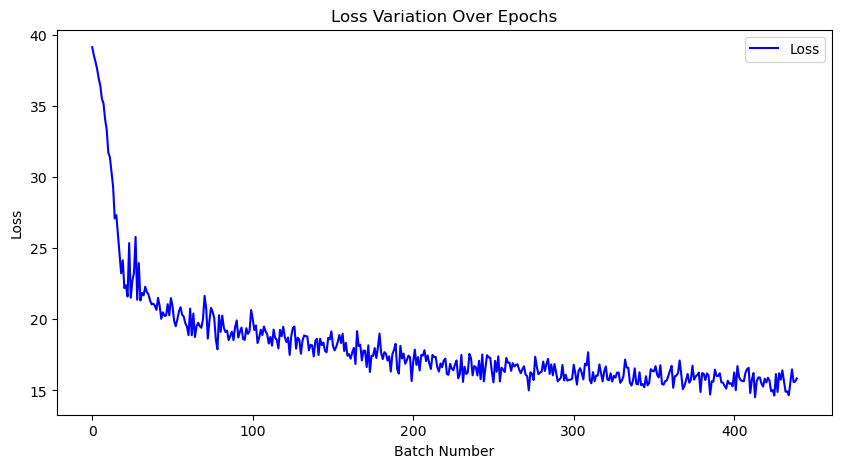

['unive', 'mathe', 'neuromoctisat', 'enginiages', 'previg', 'compurum', 'gradien', 'adminige']
['masticcerems', 'differee', 'umbreles', 'mond', 'almost']
['applicks', 'seck', 'jeal', 'awestecod', 'assistibess', 'secursas', 'equatie', 'capabie', 'importy', 'effectiand']
['religion', 'passaby', 'intellecturel', 'obviong', 'beautifinmma', 'chemice', 'warnian']


In [14]:
embed_dim = 10  # Size of the embedding vectors
hidden_size = 20  # Size of the hidden state
epochs = 5 
batch_size = 100
LEARNING_RATE = 0.005

model = autocompleteModel(alphabet_size, embed_dim, hidden_size, num_layers)
model.trainModel(vocab, epochs, batch_size) 

print(model.autocomplete(test_set1))
print(model.autocomplete(test_set2))
print(model.autocomplete(test_set3))
print(model.autocomplete(test_set4))

/tmp/ipykernel_2024147/2522089182.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_numlist = torch.tensor(word_as_numlist[:WORD_SIZE-1])
/tmp/ipykernel_2024147/2522089182.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_numlist = torch.tensor(word_as_numlist[1:WORD_SIZE])


Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9


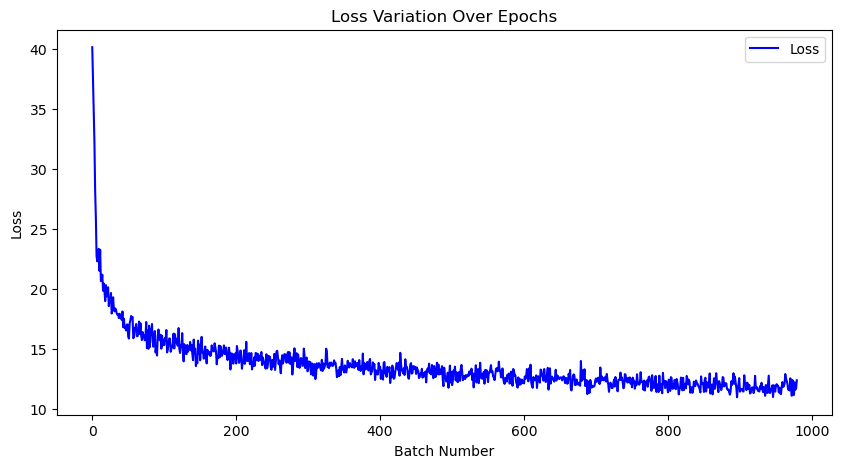

['univest', 'mather', 'neuron', 'enginer', 'prevent', 'compunta', 'gradia', 'adminititive']
['mast', 'differed', 'umbrel', 'mondear', 'almon']
['applicative', 'secriffic', 'jealis', 'awes', 'assists', 'secure', 'equation', 'capaber', 'import', 'effectics']
['religiont', 'passable', 'intellecture', 'obvious', 'beautific', 'chemicounded', 'warnia']


In [15]:
embed_dim = 40  # Size of the embedding vectors
hidden_size = 80  # Size of the hidden state
epochs = 10 
batch_size = 90
LEARNING_RATE = 0.005


model = autocompleteModel(alphabet_size, embed_dim, hidden_size, num_layers)
model.trainModel(vocab, epochs, batch_size)  

print(model.autocomplete(test_set1))
print(model.autocomplete(test_set2))
print(model.autocomplete(test_set3))
print(model.autocomplete(test_set4))

/tmp/ipykernel_2029207/2522089182.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_numlist = torch.tensor(word_as_numlist[:WORD_SIZE-1])
/tmp/ipykernel_2029207/2522089182.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_numlist = torch.tensor(word_as_numlist[1:WORD_SIZE])


Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9


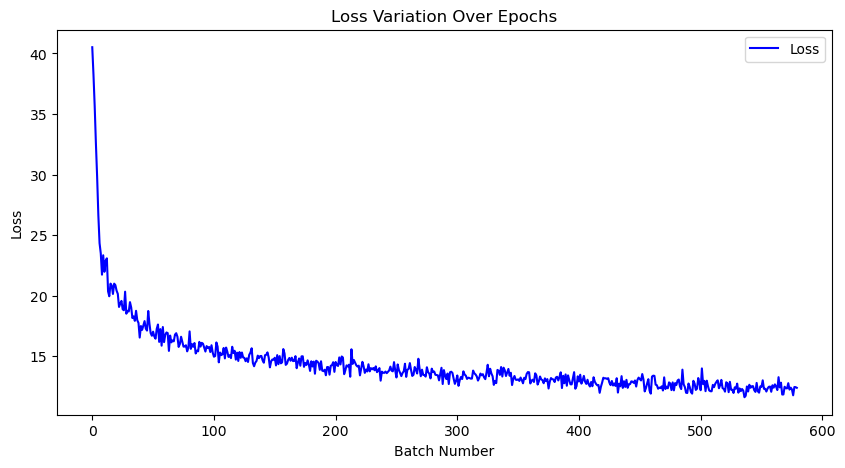

['unive', 'mathephand', 'neurovers', 'engines', 'previding', 'compution', 'gradice', 'adminitation']
['mastance', 'differents', 'umbreliad', 'mond', 'almoe']
['application', 'secsors', 'jeal', 'awess', 'assistion', 'securess', 'equation', 'capable', 'importisture', 'effectionslyw']
['religions', 'passable', 'intellectures', 'obvior', 'beautify', 'chemicila', 'warnion']


In [9]:
embed_dim = 40  # Size of the embedding vectors
hidden_size = 80  # Size of the hidden state
epochs = 10 
batch_size = 150
LEARNING_RATE = 0.005

model = autocompleteModel(alphabet_size, embed_dim, hidden_size, num_layers)
model.trainModel(vocab, epochs, batch_size) 

print(model.autocomplete(test_set1))
print(model.autocomplete(test_set2))
print(model.autocomplete(test_set3))
print(model.autocomplete(test_set4))

/tmp/ipykernel_2029207/2522089182.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_numlist = torch.tensor(word_as_numlist[:WORD_SIZE-1])
/tmp/ipykernel_2029207/2522089182.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_numlist = torch.tensor(word_as_numlist[1:WORD_SIZE])


Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9


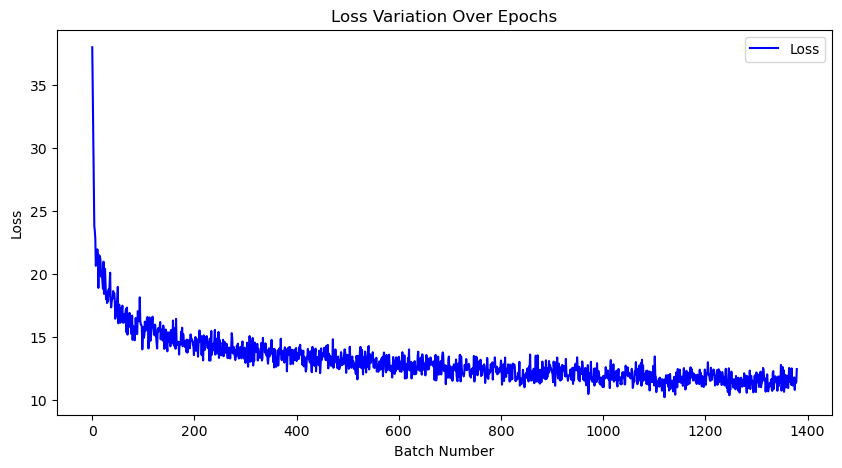

['universigner', 'mathemina', 'neurons', 'enginds', 'previor', 'computing', 'gradia', 'adminitle']
['mastic', 'differed', 'umbrel', 'mondratt', 'almonie']
['applicatiquen', 'secial', 'jealding', 'awest', 'assisting', 'secure', 'equative', 'capabie', 'importice', 'effective']
['religions', 'passabdities', 'intellectue', 'obvione', 'beautiflent', 'chemicant', 'warnized']


In [20]:

# Hyperparameters
embed_dim = 40  # Size of the embedding vectors
hidden_size = 80 # Size of the hidden state
epochs = 10
batch_size = 64
LEARNING_RATE = 0.005

model = autocompleteModel(alphabet_size, embed_dim, hidden_size, num_layers)
model.trainModel(vocab, epochs, batch_size) 

print(model.autocomplete(test_set1))
print(model.autocomplete(test_set2))
print(model.autocomplete(test_set3))
print(model.autocomplete(test_set4))

/tmp/ipykernel_2029207/2522089182.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_numlist = torch.tensor(word_as_numlist[:WORD_SIZE-1])
/tmp/ipykernel_2029207/2522089182.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_numlist = torch.tensor(word_as_numlist[1:WORD_SIZE])


Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4


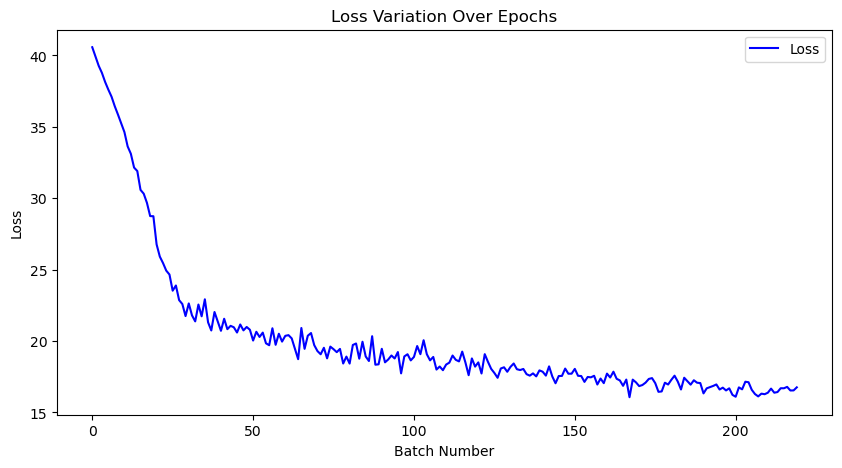

['unives', 'mather', 'neurone', 'engines', 'prevowhion', 'compuctumied', 'gradite', 'adminings']
['mast', 'differed', 'umbrelon', 'mondqxerien', 'almorore']
['applicile', 'secraces', 'jeall', 'awesgor', 'assist', 'securives', 'equatings', 'capabal', 'importionesi', 'effectinc']
['religior', 'passabty', 'intellectuat', 'obviore', 'beautifs', 'chemic', 'warnitad']


In [24]:
embed_dim = 40  # Size of the embedding vectors
hidden_size = 80  # Size of the hidden state
epochs = 5 
batch_size = 200
LEARNING_RATE = 0.001

model = autocompleteModel(alphabet_size, embed_dim, hidden_size, num_layers)
model.trainModel(vocab, epochs, batch_size) 

print(model.autocomplete(test_set1))
print(model.autocomplete(test_set2))
print(model.autocomplete(test_set3))
print(model.autocomplete(test_set4))

/tmp/ipykernel_2029207/2522089182.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_numlist = torch.tensor(word_as_numlist[:WORD_SIZE-1])
/tmp/ipykernel_2029207/2522089182.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_numlist = torch.tensor(word_as_numlist[1:WORD_SIZE])


Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9


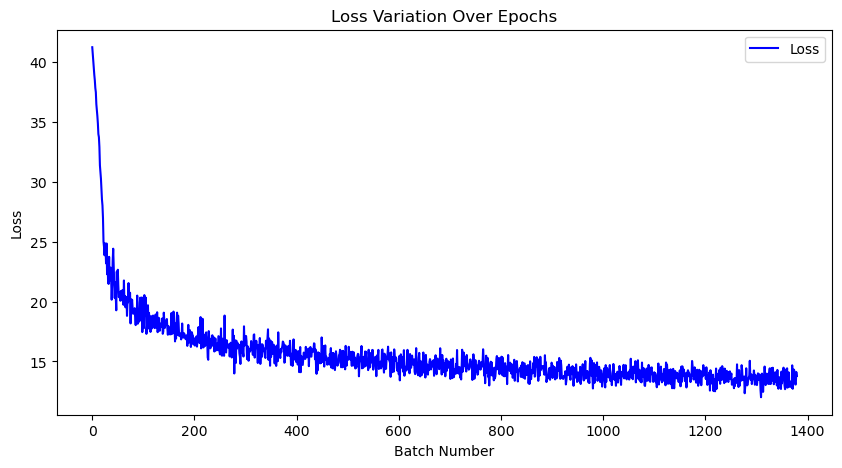

['unived', 'matheral', 'neurome', 'enging', 'prevers', 'compuleny', 'gradity', 'adminits']
['masts', 'differents', 'umbreli', 'monder', 'almotest']
['applict', 'secroom', 'jeald', 'awes', 'assistiballin', 'securalitions', 'equation', 'capabl', 'importiogs', 'effectinanati']
['religions', 'passablos', 'intellecture', 'obviols', 'beautif', 'chemicitat', 'warnications']


In [25]:
embed_dim = 40  # Size of the embedding vectors
hidden_size = 80  # Size of the hidden state
epochs = 10
batch_size = 64
LEARNING_RATE = 0.001

model = autocompleteModel(alphabet_size, embed_dim, hidden_size, num_layers)
model.trainModel(vocab, epochs, batch_size) 

print(model.autocomplete(test_set1))
print(model.autocomplete(test_set2))
print(model.autocomplete(test_set3))
print(model.autocomplete(test_set4))